# 4개 모델 성능 비교(통합데이터)
```
    Model         Accuracy Flood Recall  ROC AUC
RandomForest        0.980      0.850      0.970
XGBoost             0.964      0.876      0.977
LSTM+CNN            0.587      0.000      0.769
Transformer+SMOTE   0.740      0.910      0.874

최고의 모델은 RANDOMFOREST(통합)
Transformer+SMOTE는 침수 Recall과 AUC에서 강점을 보이며, 실사용 시 "침수 탐지"가 핵심이라면 매우 효과적

해석 요약 테이블
     모델          Accuracy   Recall    ROC AUC    Precision    F1-score
RandomForest        0.980      0.850     0.970       0.960        0.920
XGBoost             0.964      0.876     0.977       0.816        0.845
LSTM+CNN            0.587      0.000     0.769       0.196        0.320
Transformer+SMOTE   0.740      0.910     0.874       0.290        0.440
```

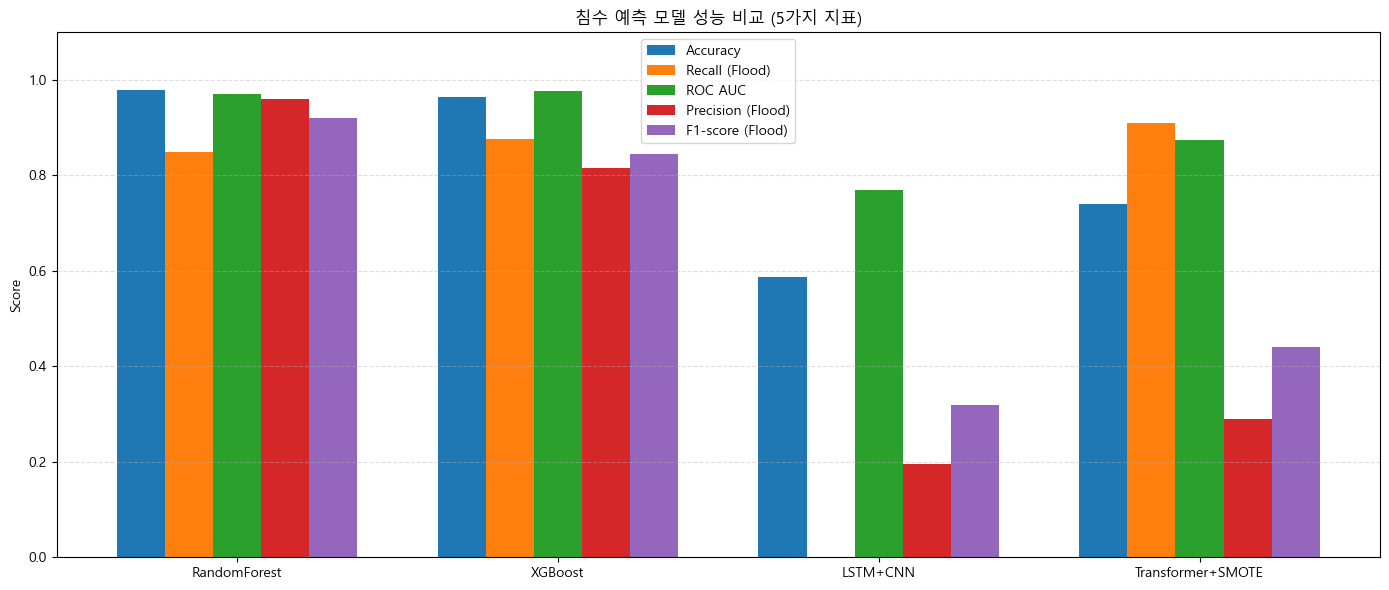

In [20]:
import matplotlib.pyplot as plt

# 모델 이름
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer+SMOTE"]

# 각 성능 지표
accuracy =     [0.980, 0.964, 0.587, 0.740]
recall =       [0.850, 0.876, 0.000, 0.910]   # 침수 Recall
roc_auc =      [0.970, 0.977, 0.769, 0.874]
precision =    [0.960, 0.816, 0.196, 0.290]   # 침수 Precision
f1_score =     [0.920, 0.845, 0.320, 0.440]   # 침수 F1-score

metrics = [accuracy, recall, roc_auc, precision, f1_score]
labels = ["Accuracy", "Recall (Flood)", "ROC AUC", "Precision (Flood)", "F1-score (Flood)"]

x = range(len(models))
bar_width = 0.15

plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics):
    plt.bar([p + i * bar_width for p in x], metric, width=bar_width, label=labels[i])

plt.xticks([p + 2 * bar_width for p in x], models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("침수 예측 모델 성능 비교 (5가지 지표)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

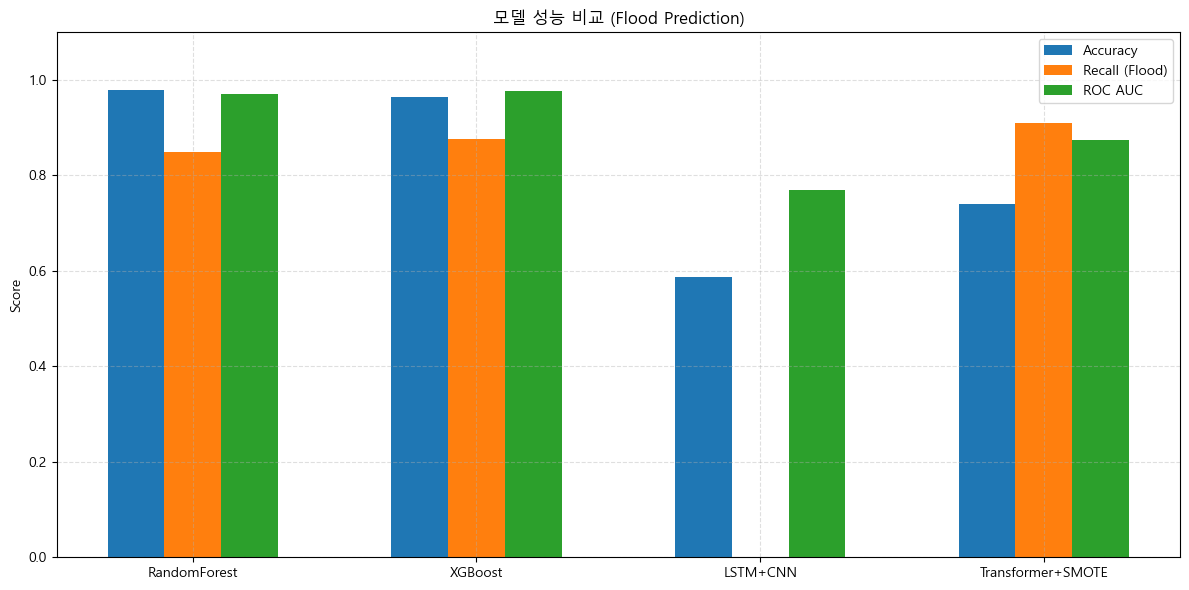

In [19]:
import matplotlib.pyplot as plt

# 모델 이름
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer+SMOTE"]

# 각 모델의 성능 지표
accuracy =     [0.980,     0.964,      0.587,         0.740]
recall_flood = [0.850,     0.876,      0.000,         0.910]  # 침수 클래스 recall
roc_auc =      [0.970,     0.977,      0.769,         0.874]

x = range(len(models))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracy, width=0.2, label='Accuracy', align='center')
plt.bar([i + 0.2 for i in x], recall_flood, width=0.2, label='Recall (Flood)', align='center')
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label='ROC AUC', align='center')

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.1)
plt.title("모델 성능 비교 (Flood Prediction)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# 한글설정, 워닝제거

In [1]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# Transformer + SMOTE

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Positional Encoding 레이어 정의
class PositionalEncoding(tf.keras.layers.Layer):
    def call(self, x):
        seq_len = tf.shape(x)[1]
        d_model = tf.shape(x)[2]
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]

        angle_rates = 1 / tf.pow(10000., (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = pos * angle_rates

        # sin 적용 (짝수), cos 적용 (홀수)
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return x + pos_encoding

# Transformer Block 정의
def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn = tf.keras.Sequential([
        Dense(ff_dim, activation='relu'),
        Dense(inputs.shape[-1])
    ])
    ffn_output = ffn(out1)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return Dropout(dropout_rate)(out2)

# Transformer 모델 정의
def build_transformer_model(input_shape, num_blocks=2):
    inputs = Input(shape=input_shape)
    x = PositionalEncoding()(inputs)
    for _ in range(num_blocks):
        x = transformer_block(x, num_heads=2, key_dim=32, ff_dim=64)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

# 데이터 불러오기 및 전처리 + 시계열 변환
df = pd.read_csv('asos_seoul_daily_enriched.csv')
features = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm', 'avgTs', 'avgTd', 'avgPs']
target = 'flood_risk'

df = df.dropna(subset=features + [target])
X_raw = df[features].values
y = df[target].values

# 시계열 슬라이딩 윈도우 구성
def create_sequences(X, y, window_size=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size + 1):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size-1])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_raw, y, window_size=7)

# 훈련/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# 2D -> 2D reshape 후 SMOTE 적용
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_flat, y_train)
X_train_res = X_train_res.reshape(-1, 7, len(features))  # 다시 시계열 형태로

# 학습
model = build_transformer_model((7, len(features)))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    X_train_res, y_train_res,
    epochs=15, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# 모델 저장
model.save("transformer_smote_daily.h5")

Epoch 1/15
125/125 [==============================] - 4s 18ms/step - loss: 0.6682 - accuracy: 0.6069 - val_loss: 0.9872 - val_accuracy: 0.0000e+00
Epoch 2/15
125/125 [==============================] - 2s 13ms/step - loss: 0.6640 - accuracy: 0.6192 - val_loss: 1.0208 - val_accuracy: 0.0000e+00
Epoch 3/15
125/125 [==============================] - 2s 14ms/step - loss: 0.6576 - accuracy: 0.6240 - val_loss: 0.9596 - val_accuracy: 0.0000e+00
Epoch 4/15
125/125 [==============================] - 2s 14ms/step - loss: 0.6459 - accuracy: 0.6285 - val_loss: 0.9460 - val_accuracy: 0.0000e+00
Epoch 5/15
125/125 [==============================] - 2s 14ms/step - loss: 0.5903 - accuracy: 0.6704 - val_loss: 0.6476 - val_accuracy: 0.6787
Epoch 6/15
125/125 [==============================] - 2s 14ms/step - loss: 0.5091 - accuracy: 0.7503 - val_loss: 0.5533 - val_accuracy: 0.7651
Epoch 7/15
125/125 [==============================] - 2s 14ms/step - loss: 0.4867 - accuracy: 0.7477 - val_loss: 0.4562 - val_

# 성능 요약
```
SMOTE + Transformer 결과를 보면 **소수 클래스(침수)의 재현율이 91%**로 상당히 높아졌고,
ROC AUC도 0.87로 꽤 우수함. 
Precision은 낮지만 "침수를 놓치지 않는" 측면에서는 큰 의미가 있음.
```

# 시각화

# 학습 곡선 시각화

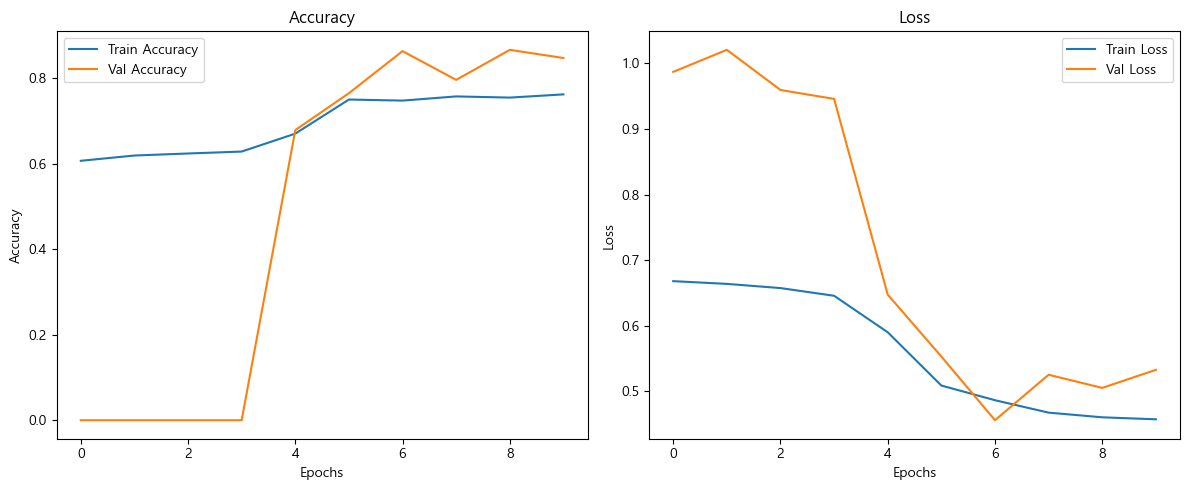

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Confusion Matrix 시각화

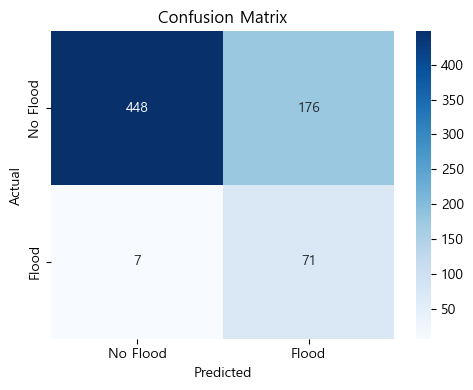

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_confusion(y_test, y_pred)

# Precision-Recall & ROC Curve

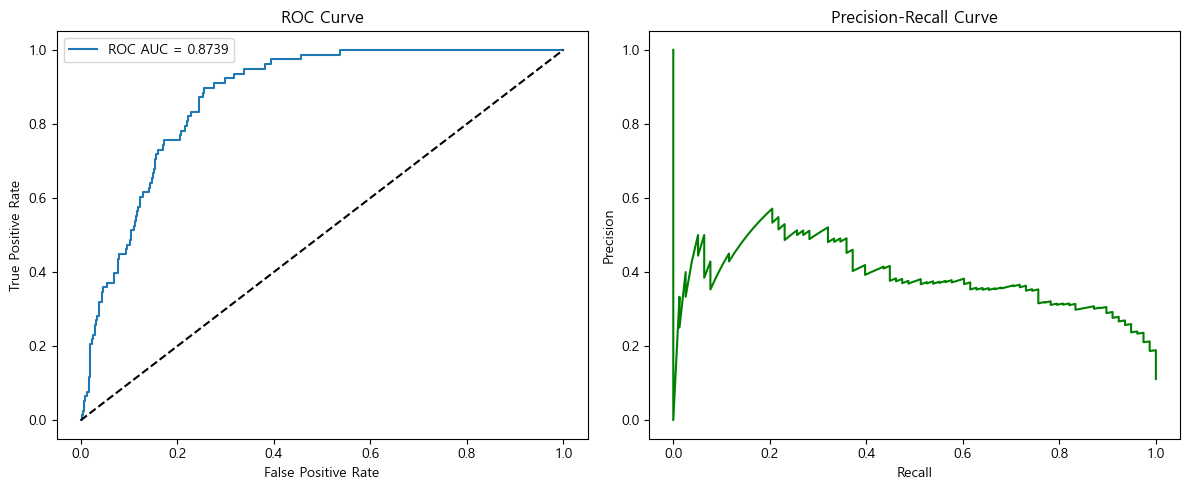

In [15]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_pr(y_true, y_proba):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    plt.figure(figsize=(12, 5))

    # ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # PR
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color="green")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")

    plt.tight_layout()
    plt.show()

plot_roc_pr(y_test, y_pred_proba)

# 모델 저장 및 불러오기

In [16]:
# 모델 저장 (전체 모델 구조 + 가중치)
model.save("transformer_flood_model.h5")
print(" Transformer 모델 저장 완료: transformer_flood_model.h5")

 Transformer 모델 저장 완료: transformer_flood_model.h5


# 오류 수정하기

In [17]:
# 이거 불러오는데 오류나는데 나중에 수정해야함~
from tensorflow.keras.models import load_model
# 모델 불러오기
model = load_model("transformer_flood_model.h5")
print(" Transformer 모델 불러오기 완료")

ValueError: Unknown layer: PositionalEncoding. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.